In [ ]:
import pytest
import torch

import triton
import triton.language as tl


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


@triton.jit
def _attn_fwd_inner(acc, l_i, m_i, q,
                    K_block_ptr, V_block_ptr,
                    start_m, qk_scale,
                    BLOCK_M: tl.constexpr, HEAD_DIM: tl.constexpr, BLOCK_N: tl.constexpr,
                    STAGE: tl.constexpr, offs_m: tl.constexpr, offs_n: tl.constexpr,
                    N_CTX: tl.constexpr, fp8_v: tl.constexpr):

    if STAGE == 1:
        lo, hi = 0, start_m * BLOCK_M
    elif STAGE == 2:
        lo, hi = start_m * BLOCK_M, (start_m + 1) * BLOCK_M
        lo = tl.multiple_of(lo, BLOCK_M)
    else:
        lo, hi = 0, N_CTX
    K_block_ptr = tl.advance(K_block_ptr, (0, lo))
    V_block_ptr = tl.advance(V_block_ptr, (lo, 0))
    # loop over k, v and update accumulator
    for start_n in range(lo, hi, BLOCK_N):
        start_n = tl.multiple_of(start_n, BLOCK_N)
        # compute qk
        k = tl.load(K_block_ptr)
        qk = tl.dot(q, k)
        if STAGE == 2:
            mask = offs_m[:, None] >= (start_n + offs_n[None, :])
            qk = qk * qk_scale + tl.where(mask, 0, -1.0e6)
            m_ij = tl.maximum(m_i, tl.max(qk, 1))
            qk -= m_ij[:, None]
        else:
            m_ij = tl.maximum(m_i, tl.max(qk, 1) * qk_scale)
            qk = qk * qk_scale - m_ij[:, None]
        p = tl.math.exp2(qk)
        l_ij = tl.sum(p, 1)
        # update m_i and l_i
        alpha = tl.math.exp2(m_i - m_ij)
        l_i = l_i * alpha + l_ij
        acc = acc * alpha[:, None]
        # update acc
        v = tl.load(V_block_ptr)
        if fp8_v:
            p = p.to(tl.float8e5)
        else:
            p = p.to(tl.float16)
        acc = tl.dot(p, v, acc)
        # update m_i and l_i
        m_i = m_ij
        V_block_ptr = tl.advance(V_block_ptr, (BLOCK_N, 0))
        K_block_ptr = tl.advance(K_block_ptr, (0, BLOCK_N))
    return acc, l_i, m_i

configs = [
    triton.Config({'BLOCK_M': BM, 'BLOCK_N': BN}, num_stages=s, num_warps=w) \
    for BM in [64, 128]\
    for BN in [32, 64]\
    for s in ([1] if is_hip() else [3, 4, 7])\
    for w in [4, 8]\
]


def keep(conf):
    BLOCK_M = conf.kwargs["BLOCK_M"]
    BLOCK_N = conf.kwargs["BLOCK_N"]
    if BLOCK_M * BLOCK_N < 128 * 128 and conf.num_warps == 8:
        return False
    return True


@triton.autotune(list(filter(keep, configs)), key=["N_CTX", "HEAD_DIM"])
@triton.jit
def _attn_fwd(Q, K, V, sm_scale, M, Out,
              stride_qz, stride_qh, stride_qm, stride_qk,
              stride_kz, stride_kh, stride_kn, stride_kk,
              stride_vz, stride_vh, stride_vk, stride_vn,
              stride_oz, stride_oh, stride_om, stride_on,
              Z, H, N_CTX,
              HEAD_DIM: tl.constexpr,
              BLOCK_M: tl.constexpr,
              BLOCK_N: tl.constexpr,
              STAGE: tl.constexpr
              ):
    tl.static_assert(BLOCK_N <= HEAD_DIM)
    start_m = tl.program_id(0)
    off_hz = tl.program_id(1)
    off_z = off_hz // H
    off_h = off_hz % H
    qvk_offset = off_z.to(tl.int64) * stride_qz + off_h.to(tl.int64) * stride_qh

    # block pointers
    Q_block_ptr = tl.make_block_ptr(
        base=Q + qvk_offset,
        shape=(N_CTX, HEAD_DIM),
        strides=(stride_qm, stride_qk),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, HEAD_DIM),
        order=(1, 0),
    )
    v_order: tl.constexpr = (0, 1) if V.dtype.element_ty == tl.float8e5 else (1, 0)
    V_block_ptr = tl.make_block_ptr(
        base=V + qvk_offset,
        shape=(N_CTX, HEAD_DIM),
        strides=(stride_vk, stride_vn),
        offsets=(0, 0),
        block_shape=(BLOCK_N, HEAD_DIM),
        order=v_order,
    )
    K_block_ptr = tl.make_block_ptr(
        base=K + qvk_offset,
        shape=(HEAD_DIM, N_CTX),
        strides=(stride_kk, stride_kn),
        offsets=(0, 0),
        block_shape=(HEAD_DIM, BLOCK_N),
        order=(0, 1),
    )
    O_block_ptr = tl.make_block_ptr(
        base=Out + qvk_offset,
        shape=(N_CTX, HEAD_DIM),
        strides=(stride_om, stride_on),
        offsets=(start_m * BLOCK_M, 0),
        block_shape=(BLOCK_M, HEAD_DIM),
        order=(1, 0),
    )
    # initialize offsets
    offs_m = start_m * BLOCK_M + tl.arange(0, BLOCK_M)
    offs_n = tl.arange(0, BLOCK_N)
    # initialize pointer to m and l
    m_i = tl.zeros([BLOCK_M], dtype=tl.float32) - float("inf")
    l_i = tl.zeros([BLOCK_M], dtype=tl.float32) + 1.0
    acc = tl.zeros([BLOCK_M, HEAD_DIM], dtype=tl.float32)
    # load scales
    qk_scale = sm_scale
    qk_scale *= 1.44269504
    # load q
    q = tl.load(Q_block_ptr)
    if STAGE & 1:
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,
                                        start_m, qk_scale,
                                        BLOCK_M, HEAD_DIM, BLOCK_N,
                                        4 - STAGE, offs_m, offs_n, N_CTX, V.dtype.element_ty == tl.float8e5
                                        )
    # on-band
    if STAGE & 2:
        acc, l_i, m_i = _attn_fwd_inner(acc, l_i, m_i, q, K_block_ptr, V_block_ptr,
                                        start_m, qk_scale,
                                        BLOCK_M, HEAD_DIM, BLOCK_N,
                                        2, offs_m, offs_n, N_CTX, V.dtype.element_ty == tl.float8e5
                                        )
    m_i += tl.math.log2(l_i)
    acc = acc / l_i[:, None]
    m_ptrs = M + off_hz * N_CTX + offs_m
    tl.store(m_ptrs, m_i)
    tl.store(O_block_ptr, acc.to(Out.type.element_ty))


@triton.jit
def _attn_bwd_preprocess(O, DO,
                         Delta,
                         Z, H, N_CTX,
                         BLOCK_M: tl.constexpr, HEAD_DIM: tl.constexpr
                         ):
    off_m = tl.program_id(0) * BLOCK_M + tl.arange(0, BLOCK_M)
    off_hz = tl.program_id(1)
    off_n = tl.arange(0, HEAD_DIM)
    # load
    o = tl.load(O + off_hz * HEAD_DIM * N_CTX + off_m[:, None] * HEAD_DIM + off_n[None, :])
    do = tl.load(DO + off_hz * HEAD_DIM * N_CTX + off_m[:, None] * HEAD_DIM + off_n[None, :]).to(tl.float32)
    delta = tl.sum(o * do, axis=1)
    # write back
    tl.store(Delta + off_hz * N_CTX + off_m, delta)


# The main inner-loop logic for computing dK and dV.
@triton.jit
def _attn_bwd_dkdv(dk, dv,
                   Q, k, v, sm_scale,
                   DO,
                   M, D,
                   stride_tok, stride_d,
                   H, N_CTX, BLOCK_M1: tl.constexpr,
                   BLOCK_N1: tl.constexpr,
                   HEAD_DIM: tl.constexpr,
                   start_n, start_m, num_steps,
                   MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M1)
    offs_n = start_n + tl.arange(0, BLOCK_N1)
    offs_k = tl.arange(0, HEAD_DIM)
    qT_ptrs = Q + offs_m[None, :] * stride_tok + offs_k[:, None] * stride_d
    do_ptrs = DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.static_assert(BLOCK_N1 % BLOCK_M1 == 0)
    curr_m = start_m
    step_m = BLOCK_M1
    for blk_idx in range(num_steps):
        qT = tl.load(qT_ptrs)
        offs_m = curr_m + tl.arange(0, BLOCK_M1)
        m = tl.load(M + offs_m)
        qkT = tl.dot(k, qT)
        pT = tl.math.exp2(qkT - m[None, :])
        if MASK:
            mask = (offs_m[None, :] >= offs_n[:, None])
            pT = tl.where(mask, pT, 0.0)
        do = tl.load(do_ptrs)
        # Compute dV
        ppT = pT
        ppT = ppT.to(tl.float16)
        dv += tl.dot(ppT, do)
        # D  is pre-divided by ds_scale
        Di = tl.load(D + offs_m)
        # Compute dP and dS
        dpT = tl.dot(v, tl.trans(do)).to(tl.float32)
        dsT = pT * (dpT - Di[None, :])
        dsT = dsT.to(tl.float16)
        dk += tl.dot(dsT, tl.trans(qT))
        # Increment pointers
        curr_m += step_m
        qT_ptrs += step_m * stride_tok
        do_ptrs += step_m * stride_tok
    return dk, dv


# the main inner-loop logic for computing dQ
@triton.jit
def _attn_bwd_dq(dq, q, K, V,
                 do, m, D,
                 stride_tok, stride_d,
                 H, N_CTX,
                 BLOCK_M2: tl.constexpr,
                 BLOCK_N2: tl.constexpr,
                 HEAD_DIM: tl.constexpr,
                 start_m, start_n, num_steps,
                 MASK: tl.constexpr):
    offs_m = start_m + tl.arange(0, BLOCK_M2)
    offs_n = start_n + tl.arange(0, BLOCK_N2)
    offs_k = tl.arange(0, HEAD_DIM)
    kT_ptrs = K + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    vT_ptrs = V + offs_n[None, :] * stride_tok + offs_k[:, None] * stride_d
    # D (= delta) is pre-divided by ds_scale.
    Di = tl.load(D + offs_m)
    # BLOCK_M2 must be a multiple of BLOCK_N2, otherwise the code wouldn't work.
    tl.static_assert(BLOCK_M2 % BLOCK_N2 == 0)
    curr_n = start_n
    step_n = BLOCK_N2
    for blk_idx in range(num_steps):
        kT = tl.load(kT_ptrs)
        vT = tl.load(vT_ptrs)
        qk = tl.dot(q, kT)
        p = tl.math.exp2(qk - m)
        # Autoregressive masking.
        if MASK:
            offs_n = curr_n + tl.arange(0, BLOCK_N2)
            mask = (offs_m[:, None] >= offs_n[None, :])
            p = tl.where(mask, p, 0.0)
        # Compute dP and dS.
        dp = tl.dot(do, vT).to(tl.float32)
        ds = p * (dp - Di[:, None])
        ds = ds.to(tl.float16)
        # Compute dQ.
        dq += tl.dot(ds, tl.trans(kT))
        # Increment pointers.
        curr_n += step_n
        kT_ptrs += step_n * stride_tok
        vT_ptrs += step_n * stride_tok
    return dq


@triton.jit
def _attn_bwd(Q, K, V, sm_scale,
              DO,
              DQ, DK, DV,
              M, D,
              stride_z, stride_h, stride_tok, stride_d,
              H, N_CTX,
              BLOCK_M1: tl.constexpr,
              BLOCK_N1: tl.constexpr,
              BLOCK_M2: tl.constexpr,
              BLOCK_N2: tl.constexpr,
              BLK_SLICE_FACTOR: tl.constexpr,
              HEAD_DIM: tl.constexpr):
    LN2: tl.constexpr = 0.6931471824645996

    bhid = tl.program_id(2)
    off_chz = (bhid * N_CTX).to(tl.int64)
    adj = (stride_h * (bhid % H) + stride_z * (bhid // H)).to(tl.int64)
    pid = tl.program_id(0)

    Q += adj
    K += adj
    V += adj
    DO += adj
    DQ += adj
    DK += adj
    DV += adj
    M += off_chz
    D += off_chz

    # load scales
    offs_k = tl.arange(0, HEAD_DIM)

    start_n = pid * BLOCK_N1
    start_m = start_n

    MASK_BLOCK_M1: tl.constexpr = BLOCK_M1 // BLK_SLICE_FACTOR
    offs_n = start_n + tl.arange(0, BLOCK_N1)

    dv = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)
    dk = tl.zeros([BLOCK_N1, HEAD_DIM], dtype=tl.float32)

    # load K and V
    k = tl.load(K + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)
    v = tl.load(V + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d)

    num_steps = BLOCK_N1 // MASK_BLOCK_M1

    dk, dv = _attn_bwd_dkdv(dk, dv,
                            Q, k, v, sm_scale,
                            DO,
                            M, D,
                            stride_tok, stride_d,
                            H, N_CTX,
                            MASK_BLOCK_M1, BLOCK_N1, HEAD_DIM,
                            start_n, start_m, num_steps,
                            MASK=True
                            )

    start_m += num_steps * MASK_BLOCK_M1
    num_steps = (N_CTX - start_m) // BLOCK_M1

    # Compute dK and dV for non-masked blocks.
    dk, dv = _attn_bwd_dkdv(
        dk, dv,
        Q, k, v, sm_scale,
        DO,
        M, D,
        stride_tok, stride_d,
        H, N_CTX,
        BLOCK_M1, BLOCK_N1, HEAD_DIM,
        start_n, start_m, num_steps,
        MASK=False
    )

    dv_ptrs = DV + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dv_ptrs, dv)

    # Write back dK.
    dk *= sm_scale
    dk_ptrs = DK + offs_n[:, None] * stride_tok + offs_k[None, :] * stride_d
    tl.store(dk_ptrs, dk)

    # Compute dQ
    start_m = pid * BLOCK_M2
    end_n = start_m + BLOCK_M2

    MASK_BLOCK_N2: tl.constexpr = BLOCK_N2 // BLK_SLICE_FACTOR
    offs_m = start_m + tl.arange(0, BLOCK_M2)

    q = tl.load(Q + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)
    dq = tl.zeros([BLOCK_M2, HEAD_DIM], dtype=tl.float32)
    do = tl.load(DO + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d)

    m = tl.load(M + offs_m)
    m = m[:, None]

    num_steps = BLOCK_M2 // MASK_BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,
                      do, m, D,
                      stride_tok, stride_d,
                      H, N_CTX,
                      BLOCK_M2, MASK_BLOCK_N2, HEAD_DIM,
                      start_m, end_n - num_steps * MASK_BLOCK_N2, num_steps,
                      MASK=True
                      )
    end_n -= num_steps * MASK_BLOCK_N2

    num_steps = end_n // BLOCK_N2
    dq = _attn_bwd_dq(dq, q, K, V,
                      do, m, D,
                      stride_tok, stride_d,
                      H, N_CTX,
                      BLOCK_M2, BLOCK_N2, HEAD_DIM,
                      start_m, end_n - num_steps * BLOCK_N2, num_steps,
                      MASK=False
                      )
    # Write back dQ.
    dq_ptrs = DQ + offs_m[:, None] * stride_tok + offs_k[None, :] * stride_d
    dq *= LN2
    tl.store(dq_ptrs, dq)


class _attention(torch.autograd.Function):

    @staticmethod
    def forward(ctx, q, k, v, causal, sm_scale):
        # shape constraints
        HEAD_DIM_Q, HEAD_DIM_K = q.shape[-1], k.shape[-1]
        # when v is in float8_e5m2 it is transposed.
        HEAD_DIM_V = v.shape[-1]
        assert HEAD_DIM_Q == HEAD_DIM_K and HEAD_DIM_K == HEAD_DIM_V
        assert HEAD_DIM_K in {16, 32, 64, 128, 256}
        o = torch.empty_like(q)
        stage = 3 if causal else 1
        extra_kern_args = {}
        # Tuning for AMD target
        if is_hip():
            waves_per_eu = 3 if HEAD_DIM_K <= 64 else 2
            extra_kern_args = {"waves_per_eu": waves_per_eu, "allow_flush_denorm": True}

        grid = lambda args: (triton.cdiv(q.shape[2], args["BLOCK_M"]), q.shape[0] * q.shape[1], 1)
        M = torch.empty((q.shape[0], q.shape[1], q.shape[2]), device=q.device, dtype=torch.float32)
        _attn_fwd[grid](
            q, k, v, sm_scale, M, o,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            q.shape[0], q.shape[1],
            N_CTX=q.shape[2],
            HEAD_DIM=HEAD_DIM_K,
            STAGE=stage,
            **extra_kern_args)

        ctx.save_for_backward(q, k, v, o, M)
        ctx.grid = grid
        ctx.sm_scale = sm_scale
        ctx.HEAD_DIM = HEAD_DIM_K
        ctx.causal = causal
        return o

    @staticmethod
    def backward(ctx, do):
        q, k, v, o, M = ctx.saved_tensors
        assert do.is_contiguous()
        assert q.stride() == k.stride() == v.stride() == o.stride() == do.stride()
        dq = torch.empty_like(q)
        dk = torch.empty_like(k)
        dv = torch.empty_like(v)
        BATCH, N_HEAD, N_CTX = q.shape[:3]
        PRE_BLOCK = 128
        NUM_WARPS, NUM_STAGES = 4, 5
        BLOCK_M1, BLOCK_N1, BLOCK_M2, BLOCK_N2 = 32, 128, 128, 32
        BLK_SLICE_FACTOR = 2
        RCP_LN2 = 1.4426950408889634
        arg_k = k
        arg_k = arg_k * (ctx.sm_scale * RCP_LN2)
        PRE_BLOCK = 128
        assert N_CTX % PRE_BLOCK == 0
        pre_grid = (N_CTX // PRE_BLOCK, BATCH * N_HEAD)
        delta = torch.empty_like(M)
        _attn_bwd_preprocess[pre_grid](
            o, do,
            delta,
            BATCH, N_HEAD, N_CTX,
            BLOCK_M=PRE_BLOCK, HEAD_DIM=ctx.HEAD_DIM
        )
        grid = (N_CTX // BLOCK_N1, 1, BATCH * N_HEAD)
        _attn_bwd[grid](
            q, arg_k, v, ctx.sm_scale, do, dq, dk, dv,
            M, delta,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            N_HEAD, N_CTX,
            BLOCK_M1=BLOCK_M1, BLOCK_N1=BLOCK_N1,
            BLOCK_M2=BLOCK_M2, BLOCK_N2=BLOCK_N2,
            BLK_SLICE_FACTOR=BLK_SLICE_FACTOR,
            HEAD_DIM=ctx.HEAD_DIM,
            num_warps=NUM_WARPS,
            num_stages=NUM_STAGES
        )

        return dq, dk, dv, None, None


attention = _attention.apply

@pytest.mark.parametrize("Z, H, N_CTX, HEAD_DIM", [(1, 2, 1024, 64)])
@pytest.mark.parametrize("causal", [True])
def test_op(Z, H, N_CTX, HEAD_DIM, causal, dtype=torch.float16):
    torch.manual_seed(20)
    q = (torch.empty((Z, H, N_CTX, HEAD_DIM), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    k = (torch.empty((Z, H, N_CTX, HEAD_DIM), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    v = (torch.empty((Z, H, N_CTX, HEAD_DIM), dtype=dtype, device="cuda").normal_(mean=0.0, std=0.5).requires_grad_())
    sm_scale = 0.5
    dout = torch.randn_like(q)
    # reference implementation
    M = torch.tril(torch.ones((N_CTX, N_CTX), device="cuda"))
    p = torch.matmul(q, k.transpose(2, 3)) * sm_scale
    if causal:
        p[:, :, M == 0] = float("-inf")
    p = torch.softmax(p.float(), dim=-1).half()
    # p = torch.exp(p)
    ref_out = torch.matmul(p, v)
    ref_out.backward(dout)
    ref_dv, v.grad = v.grad.clone(), None
    ref_dk, k.grad = k.grad.clone(), None
    ref_dq, q.grad = q.grad.clone(), None
    # triton implementation
    tri_out = attention(q, k, v, causal, sm_scale).half()
    tri_out.backward(dout)
    tri_dv, v.grad = v.grad.clone(), None
    tri_dk, k.grad = k.grad.clone(), None
    tri_dq, q.grad = q.grad.clone(), None
    # compare
    assert torch.allclose(ref_out, tri_out, atol=1e-2, rtol=0)
    rtol = 0.0
    if torch.version.hip is not None and triton.runtime.driver.active.get_current_target().arch == "gfx90a":
        rtol = 1e-2
    assert torch.allclose(ref_dv, tri_dv, atol=1e-2, rtol=rtol)
    assert torch.allclose(ref_dk, tri_dk, atol=1e-2, rtol=rtol)
    assert torch.allclose(ref_dq, tri_dq, atol=1e-2, rtol=rtol)


try:
    from flash_attn.flash_attn_interface import \
        flash_attn_qkvpacked_func as flash_attn_func
    HAS_FLASH = True
except BaseException:
    HAS_FLASH = False

TORCH_HAS_FP8 = hasattr(torch, 'float8_e5m2')
BATCH, N_HEADS, HEAD_DIM = 4, 32, 64
configs = []
for mode in ["fwd", "bwd"]:
    for causal in [True, False]:
        if mode == "bwd" and not causal:
            continue
        configs.append(
            triton.testing.Benchmark(
                x_names=["N_CTX"],
                x_vals=[2**i for i in range(10, 15)],
                line_arg="provider",
                line_vals=["triton-fp16"] + (["triton-fp8"] if TORCH_HAS_FP8 else []) +
                (["flash"] if HAS_FLASH else []),
                line_names=["Triton [FP16]"] + (["Triton [FP8]"] if TORCH_HAS_FP8 else []) +
                (["Flash-2"] if HAS_FLASH else []),
                styles=[("red", "-"), ("blue", "-"), ("green", "-")],
                ylabel="TFLOPS",
                plot_name=f"fused-attention-batch{BATCH}-head{N_HEADS}-d{HEAD_DIM}-{mode}-causal={causal}",
                args={
                    "H": N_HEADS,
                    "BATCH": BATCH,
                    "HEAD_DIM": HEAD_DIM,
                    "mode": mode,
                    "causal": causal,
                },
            ))



In [ ]:
import torch
import torch.nn as nn
import numpy as np
import sys
import time
from einops import rearrange

BLOCK_SIZE = 1024
NEG_INF = -1e10 # -infinity
EPSILON = 1e-10

def flash_attention_forward(Q, K, V, mask=None):
    O = torch.zeros_like(Q, requires_grad=True)
    l = torch.zeros(Q.shape[:-1])[...,None]
    m = torch.ones(Q.shape[:-1])[...,None] * NEG_INF

    O = O.to(device='cuda')
    l = l.to(device='cuda')
    m = m.to(device='cuda')

    Q_BLOCK_SIZE = min(BLOCK_SIZE, Q.shape[-1])
    KV_BLOCK_SIZE = BLOCK_SIZE

    Q_BLOCKS = torch.split(Q, Q_BLOCK_SIZE, dim=2)
    K_BLOCKS = torch.split(K, KV_BLOCK_SIZE, dim=2)
    V_BLOCKS = torch.split(V, KV_BLOCK_SIZE, dim=2)
    mask_BLOCKS = list(torch.split(mask, KV_BLOCK_SIZE, dim=1))

    Tr = len(Q_BLOCKS)
    Tc = len(K_BLOCKS)

    O_BLOCKS = list(torch.split(O, Q_BLOCK_SIZE, dim=2))
    l_BLOCKS = list(torch.split(l, Q_BLOCK_SIZE, dim=2))
    m_BLOCKS = list(torch.split(m, Q_BLOCK_SIZE, dim=2))

    for j in range(Tc):
        Kj = K_BLOCKS[j]
        Vj = V_BLOCKS[j]
        maskj = mask_BLOCKS[j]

        for i in range(Tr):
            Qi = Q_BLOCKS[i]
            Oi = O_BLOCKS[i]
            li = l_BLOCKS[i]
            mi = m_BLOCKS[i]

            scale = 1 / np.sqrt(Q.shape[-1])
            Qi_scaled  = Qi * scale

            S_ij = torch.einsum('... i d, ... j d -> ... i j', Qi_scaled, Kj)

            # Masking
            maskj_temp = rearrange(maskj, 'b j -> b 1 1 j')
            S_ij = torch.where(maskj_temp > 0, S_ij, NEG_INF)

            m_block_ij, _ = torch.max(S_ij, dim=-1, keepdims=True)
            P_ij = torch.exp(S_ij - m_block_ij)
            # Masking
            P_ij = torch.where(maskj_temp > 0, P_ij, 0.)

            l_block_ij = torch.sum(P_ij, dim=-1, keepdims=True) + EPSILON

            P_ij_Vj = torch.einsum('... i j, ... j d -> ... i d', P_ij, Vj)

            mi_new = torch.maximum(m_block_ij, mi)
            li_new = torch.exp(mi - mi_new) * li + torch.exp(m_block_ij - mi_new) * l_block_ij

            O_BLOCKS[i] = (li/li_new) * torch.exp(mi - mi_new) * Oi + (torch.exp(m_block_ij - mi_new) / li_new) * P_ij_Vj
            l_BLOCKS[i] = li_new
            m_BLOCKS[i] = mi_new

    O = torch.cat(O_BLOCKS, dim=2)
    l = torch.cat(l_BLOCKS, dim=2)
    m = torch.cat(m_BLOCKS, dim=2)
    return O, l, m

def flash_attention_backward(Q, K, V, mask, O, l, m, dO):
    Q_BLOCK_SIZE = min(BLOCK_SIZE, Q.shape[-1])
    KV_BLOCK_SIZE = BLOCK_SIZE

    Q_BLOCKS = torch.split(Q, Q_BLOCK_SIZE, dim=2)
    K_BLOCKS = torch.split(K, KV_BLOCK_SIZE, dim=2)
    V_BLOCKS = torch.split(V, KV_BLOCK_SIZE, dim=2)
    mask_BLOCKS = list(torch.split(mask, KV_BLOCK_SIZE, dim=1))

    Tr = len(Q_BLOCKS)
    Tc = len(K_BLOCKS)

    O_BLOCKS = list(torch.split(O, Q_BLOCK_SIZE, dim=2))
    dO_BLOCKS = list(torch.split(dO, Q_BLOCK_SIZE, dim=2))
    l_BLOCKS = list(torch.split(l, Q_BLOCK_SIZE, dim=2))
    m_BLOCKS = list(torch.split(m, Q_BLOCK_SIZE, dim=2))

    dQ = torch.zeros_like(Q, requires_grad=True).to(device='cuda')
    dK = torch.zeros_like(K, requires_grad=True).to(device='cuda')
    dV = torch.zeros_like(V, requires_grad=True).to(device='cuda')

    dQ_BLOCKS = list(torch.split(dQ, Q_BLOCK_SIZE, dim=2))
    dK_BLOCKS = list(torch.split(dK, KV_BLOCK_SIZE, dim=2))
    dV_BLOCKS = list(torch.split(dV, KV_BLOCK_SIZE, dim=2))

    for j in range(Tc):
        Kj = K_BLOCKS[j]
        Vj = V_BLOCKS[j]
        maskj = mask_BLOCKS[j]

        dKj_block = torch.zeros_like(dK_BLOCKS[j], requires_grad=True).to(device='cuda')
        dVj_block = torch.zeros_like(dV_BLOCKS[j], requires_grad=True).to(device='cuda')

        for i in range(Tr):
            Qi = Q_BLOCKS[i]
            Oi = O_BLOCKS[i]
            dOi = dO_BLOCKS[i]
            li = l_BLOCKS[i]
            mi = m_BLOCKS[i]

            scale = 1 / np.sqrt(Q.shape[-1])
            Qi_scaled  = Qi * scale

            S_ij = torch.einsum('... i d, ... j d -> ... i j', Qi_scaled, Kj)

            # Masking
            maskj_temp = rearrange(maskj, 'b j -> b 1 1 j')
            S_ij = torch.where(maskj_temp > 0, S_ij, NEG_INF)

            P_ij = (1/li) * torch.exp(S_ij - mi)
            # Masking
            P_ij = torch.where(maskj_temp > 0, P_ij, 0.)

            dVj_block = dVj_block + torch.einsum('... r c, ... r d -> ... c d', P_ij, dOi)
            dP_ij = torch.einsum('... r d, ... c d -> ... r c', dOi, Vj)

            Di = torch.sum(dOi * Oi, dim=-1, keepdims=True)
            dS_ij = P_ij * (dP_ij - Di)

            dQ_BLOCKS[i] = dQ_BLOCKS[i] + scale * torch.einsum('... r c, ... c d -> ... r d', dS_ij, Kj)

            dKj_block = dKj_block + scale * torch.einsum('... r c, ... r d -> ... c d', dS_ij, Qi)

        dK_BLOCKS[j] = dKj_block
        dV_BLOCKS[j] = dVj_block

    dQ = torch.cat(dQ_BLOCKS, dim=2)
    dK = torch.cat(dK_BLOCKS, dim=2)
    dV = torch.cat(dV_BLOCKS, dim=2)
    return dQ, dK, dV

def flash_attention(Q, K, V, mask):
    out = flash_attention_forward(Q, K, V, mask)
    return out[0]



N_CTX: 1024, TFLOPS: 0.001
N_CTX: 2048, TFLOPS: 0.056
N_CTX: 4096, TFLOPS: 0.064
N_CTX: 8192, TFLOPS: 0.076
N_CTX: 16384, TFLOPS: 0.082


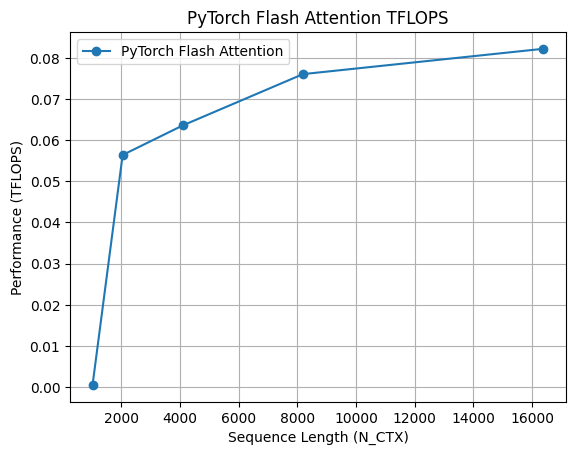

In [ ]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np

# Constants
BATCH, HEADS, HEAD_DIM = 1, 2, 64
BLOCK_SIZE = 1024

def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
  # Estimate the number of FLOPs: 2 * (QK^T + PV)
  flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
  total_flops = flops_per_batch_head * BATCH * HEADS
  tflops = total_flops / runtime / 1e12
  return tflops

def benchmark_flash_attention(N_CTX, iters=10):
  Q = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
  K = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
  V = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
  mask = torch.randint(0, 2, (BATCH, N_CTX)).to('cuda')

  total_time = 0.0
  for _ in range(iters):
    start = time.time()
    out = flash_attention_forward(Q, K, V, mask)
    out[0].backward(torch.randn_like(out[0]))
    total_time += time.time() - start

    avg_runtime = total_time / iters
    return calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)

# Sequence lengths to benchmark

ctx_sizes = [2**i for i in range(10, 15)] # Reduced range for practical execution
#Record TFLOPS for different sequence lengths

tflops_results = []
for size in ctx_sizes:
  runtime_tflops = benchmark_flash_attention(size)
  tflops_results.append(runtime_tflops)
  print(f"N_CTX: {size}, TFLOPS: {runtime_tflops:.3f}")

#Plotting results

plt.plot(ctx_sizes, tflops_results, 'o-', label='PyTorch Flash Attention')
plt.xlabel('Sequence Length (N_CTX)')
plt.ylabel('Performance (TFLOPS)')
plt.title('PyTorch Flash Attention TFLOPS')
# plt.xscale('log', base=2)
# plt.yscale('linear')
plt.legend(loc='best')
plt.grid(True)
plt.show()

N_CTX: 1024, TFLOPS: 0.001
N_CTX: 2048, TFLOPS: 1.335
N_CTX: 4096, TFLOPS: 3.212
N_CTX: 8192, TFLOPS: 4.792
N_CTX: 16384, TFLOPS: 5.291


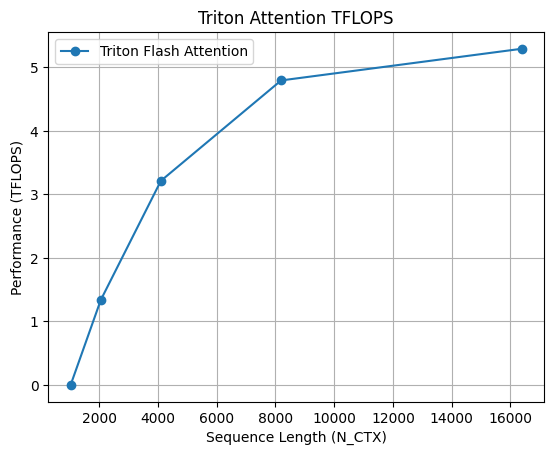

In [ ]:
import torch
import time
import matplotlib.pyplot as plt

def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
    # Estimate the number of FLOPs: 2 * (QK^T + PV)
    flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
    total_flops = flops_per_batch_head * BATCH * HEADS
    tflops = total_flops / runtime / 1e12
    return tflops

def benchmark_attention(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    sm_scale = 0.5

    # Warm-up run
    out = attention(q, k, v, causal, sm_scale)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        out = attention(q, k, v, causal, sm_scale)
        out.backward(torch.randn_like(out))
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    return calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)

def plot_tflops():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    tflops_results = []
    for size in ctx_sizes:
        runtime_tflops = benchmark_attention(size, BATCH, HEADS, HEAD_DIM, causal)
        tflops_results.append(runtime_tflops)
        print(f"N_CTX: {size}, TFLOPS: {runtime_tflops:.3f}")

    plt.plot(ctx_sizes, tflops_results, 'o-', label='Triton Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Performance (TFLOPS)')
    plt.title('Triton Attention TFLOPS')
    # plt.xscale('log', base=2)
    # plt.yscale('linear')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Run the benchmark and plot
plot_tflops()


N_CTX: 1024, Time per iteration: 0.030 sec
N_CTX: 2048, Time per iteration: 0.151 sec
N_CTX: 4096, Time per iteration: 0.526 sec
N_CTX: 8192, Time per iteration: 2.466 sec
N_CTX: 16384, Time per iteration: 8.802 sec


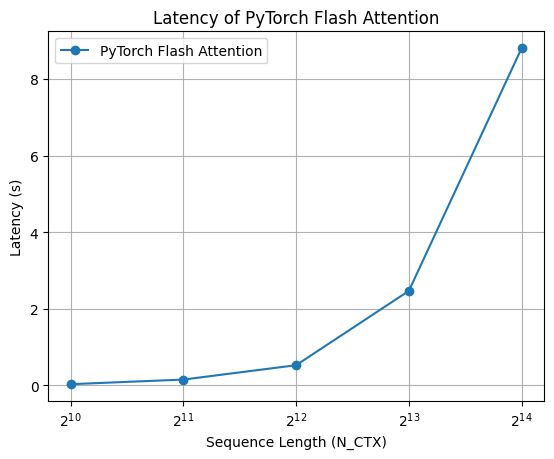

In [ ]:
BATCH, HEADS, HEAD_DIM = 1, 2, 64
BLOCK_SIZE = 1024

def benchmark_flash_attention(N_CTX, iters=10):
    Q = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
    K = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
    V = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM, requires_grad=True).to('cuda')
    mask = torch.randint(0, 2, (BATCH, N_CTX)).to('cuda')

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()  # Ensure synchronization before timing
        start = time.time()
        out = flash_attention_forward(Q, K, V, mask)
        out[0].backward(torch.randn_like(out[0]))
        torch.cuda.synchronize()  # Ensure synchronization after timing
        total_time += time.time() - start

    avg_time_per_iter = total_time / iters
    return avg_time_per_iter  # Return the average time per iteration

# Sequence lengths to benchmark
ctx_sizes = [2**i for i in range(10, 15)]

# Record execution time for different sequence lengths
times_results = []
for size in ctx_sizes:
    avg_time = benchmark_flash_attention(size)
    times_results.append(avg_time)
    print(f"N_CTX: {size}, Time per iteration: {avg_time:.3f} sec")

# Plotting execution time
plt.plot(ctx_sizes, times_results, 'o-', label='PyTorch Flash Attention')
plt.xlabel('Sequence Length (N_CTX)')
plt.ylabel('Latency (s)')
plt.title('Latency of PyTorch Flash Attention')
plt.xscale('log', base=2)
plt.legend(loc='best')
plt.grid(True)
plt.show()


N_CTX: 1024, TFLOPS: 0.465, Latency: 0.000578 s, Memory: 0.007 MB
N_CTX: 2048, TFLOPS: 1.887, Latency: 0.000569 s, Memory: 0.014 MB
N_CTX: 4096, TFLOPS: 3.777, Latency: 0.001137 s, Memory: 0.028 MB
N_CTX: 8192, TFLOPS: 8.394, Latency: 0.002047 s, Memory: 0.056 MB
N_CTX: 16384, TFLOPS: 15.504, Latency: 0.004432 s, Memory: 0.113 MB


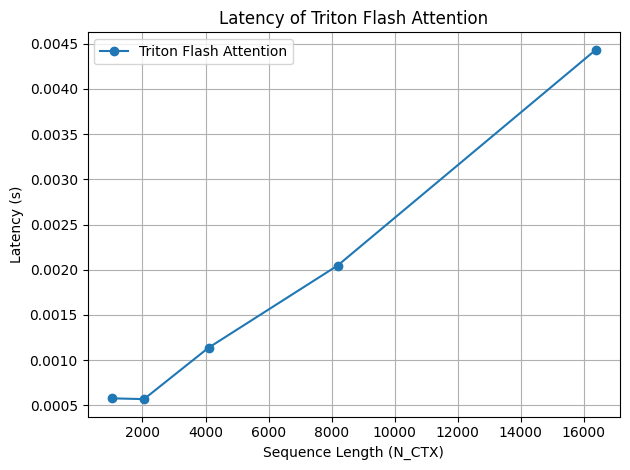

In [ ]:
import torch
import time
import matplotlib.pyplot as plt
import torch.cuda

# Function to calculate TFLOPS
def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
    flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
    total_flops = flops_per_batch_head * BATCH * HEADS
    tflops = total_flops / runtime / 1e12
    return tflops

# Function to benchmark Flash Attention and calculate metrics
def benchmark_attention(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    sm_scale = 0.5

    # Warm-up run
    out = attention(q, k, v, causal, sm_scale)

    total_time = 0.0
    total_memory = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()  # Ensure the start time is accurate
        start = time.perf_counter()

        # Measure initial memory usage
        memory_before = torch.cuda.memory_allocated()

        # Run the attention function
        out = attention(q, k, v, causal, sm_scale)

        # Measure memory usage after running attention
        memory_after = torch.cuda.memory_allocated()

        # Measure the time for one iteration
        torch.cuda.synchronize()  # Ensure the end time is accurate
        total_time += time.perf_counter() - start
        total_memory += (memory_after - memory_before)  # Memory used during one iteration

        # Backpropagation step
        out.backward(torch.randn_like(out))

    avg_runtime = total_time / iters
    avg_memory = total_memory / iters  # Average memory usage across iterations
    tflops = calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)

    return avg_runtime, avg_memory, tflops

# Function to plot TFLOPS, latency, and memory usage
def plot_metrics():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    latency_results = []
    memory_results = []
    tflops_results = []

    for size in ctx_sizes:
        avg_latency, avg_memory, runtime_tflops = benchmark_attention(size, BATCH, HEADS, HEAD_DIM, causal)

        latency_results.append(avg_latency)
        memory_results.append(avg_memory / (1024**2))  # Convert memory usage to MB
        tflops_results.append(runtime_tflops)

        print(f"N_CTX: {size}, TFLOPS: {runtime_tflops:.3f}, Latency: {avg_latency:.6f} s, Memory: {avg_memory / (1024**2):.3f} MB")

    # Plotting Results
    fig, ax1 = plt.subplots()

    # Plot Latency
    ax1.plot(ctx_sizes, latency_results, 'o-', label='Triton Flash Attention')
    ax1.set_xlabel('Sequence Length (N_CTX)')
    ax1.set_ylabel('Latency (s)')
    ax1.set_title('Latency of Triton Flash Attention')
    ax1.grid(True)
    ax1.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Run the benchmark and plot the metrics
plot_metrics()


N_CTX: 1024, TFLOPS: 0.025
N_CTX: 2048, TFLOPS: 0.026
N_CTX: 4096, TFLOPS: 0.028
N_CTX: 8192, TFLOPS: 0.026
N_CTX: 16384, TFLOPS: 0.025


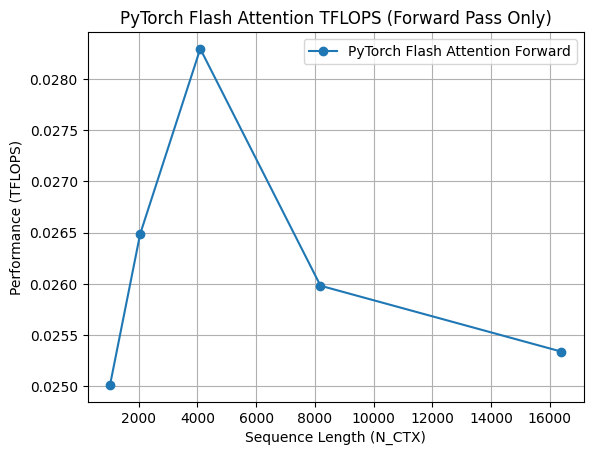

In [ ]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np

# Constants
BATCH, HEADS, HEAD_DIM = 1, 2, 64
BLOCK_SIZE = 1024

def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
    # Estimate the number of FLOPs: 2 * (QK^T + PV)
    flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
    total_flops = flops_per_batch_head * BATCH * HEADS
    tflops = total_flops / runtime / 1e12
    return tflops

def benchmark_flash_attention_forward_only(N_CTX, iters=10):
    # Random tensor inputs
    Q = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM).to('cuda')
    K = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM).to('cuda')
    V = torch.randn(BATCH, HEADS, N_CTX, HEAD_DIM).to('cuda')
    mask = torch.randint(0, 2, (BATCH, N_CTX)).to('cuda')

    total_time = 0.0
    for _ in range(iters):
        start = time.time()
        out = flash_attention_forward(Q, K, V, mask)
        torch.cuda.synchronize()  # Ensure timing is accurate
        total_time += time.time() - start

    avg_runtime = total_time / iters
    return calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)

# Sequence lengths to benchmark
ctx_sizes = [2**i for i in range(10, 15)]  # Reduced range for practical execution

# Record TFLOPS for different sequence lengths
tflops_results = []
for size in ctx_sizes:
    runtime_tflops = benchmark_flash_attention_forward_only(size)
    tflops_results.append(runtime_tflops)
    print(f"N_CTX: {size}, TFLOPS: {runtime_tflops:.3f}")

# Plotting results
plt.plot(ctx_sizes, tflops_results, 'o-', label='PyTorch Flash Attention Forward')
plt.xlabel('Sequence Length (N_CTX)')
plt.ylabel('Performance (TFLOPS)')
plt.title('PyTorch Flash Attention TFLOPS (Forward Pass Only)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


N_CTX: 1024, TFLOPS: 1.023
N_CTX: 2048, TFLOPS: 3.028
N_CTX: 4096, TFLOPS: 6.254
N_CTX: 8192, TFLOPS: 9.291
N_CTX: 16384, TFLOPS: 12.299


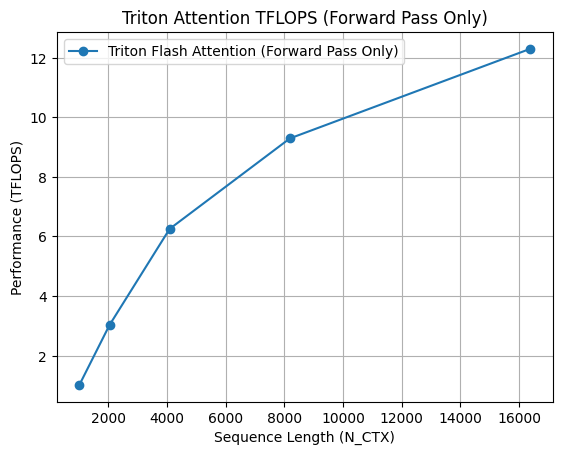

In [ ]:
import torch
import time
import matplotlib.pyplot as plt

def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
    # Estimate the number of FLOPs: 2 * (QK^T + PV)
    flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
    total_flops = flops_per_batch_head * BATCH * HEADS
    tflops = total_flops / runtime / 1e12
    return tflops

def benchmark_attention_forward_only(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    # Random tensor inputs
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    sm_scale = 0.5

    # Warm-up run
    _ = attention(q, k, v, causal, sm_scale)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        _ = attention(q, k, v, causal, sm_scale)
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    return calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)

def plot_tflops_forward_only():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    tflops_results = []
    for size in ctx_sizes:
        runtime_tflops = benchmark_attention_forward_only(size, BATCH, HEADS, HEAD_DIM, causal)
        tflops_results.append(runtime_tflops)
        print(f"N_CTX: {size}, TFLOPS: {runtime_tflops:.3f}")

    plt.plot(ctx_sizes, tflops_results, 'o-', label='Triton Flash Attention (Forward Pass Only)')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Performance (TFLOPS)')
    plt.title('Triton Attention TFLOPS (Forward Pass Only)')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Run the forward pass benchmark and plot
plot_tflops_forward_only()


N_CTX: 1024, Latency: 0.583 ms, TFLOPS: 0.460
N_CTX: 2048, Latency: 0.805 ms, TFLOPS: 1.334
N_CTX: 4096, Latency: 1.916 ms, TFLOPS: 2.242
N_CTX: 8192, Latency: 6.330 ms, TFLOPS: 2.714
N_CTX: 16384, Latency: 15.359 ms, TFLOPS: 4.474


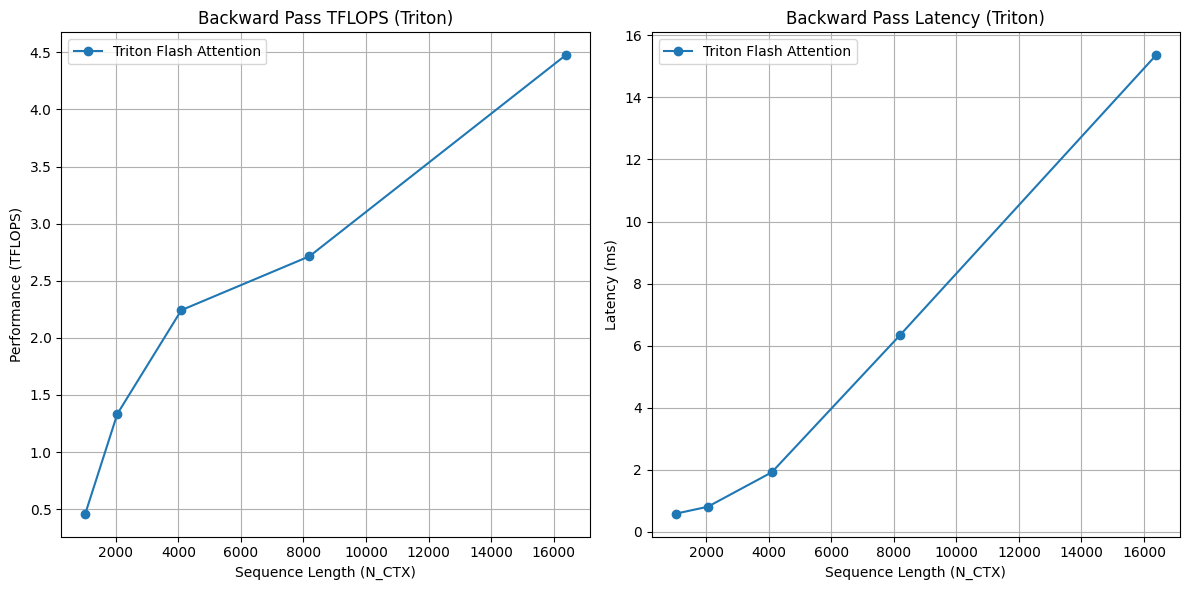

In [ ]:
import torch
import time
import matplotlib.pyplot as plt

def calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, runtime):
    # Estimate the number of FLOPs: 2 * (QK^T + PV)
    flops_per_batch_head = 2 * N_CTX**2 * HEAD_DIM
    total_flops = flops_per_batch_head * BATCH * HEADS
    tflops = total_flops / runtime / 1e12
    return tflops

def benchmark_attention_backward_triton(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    sm_scale = 0.5

    # Forward pass to generate outputs
    out = attention(q, k, v, causal, sm_scale)
    grad_out = torch.randn_like(out)

    # Warm-up backward pass
    out.backward(grad_out, retain_graph=True)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        out.backward(grad_out, retain_graph=True)
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    tflops = calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)
    return avg_runtime, tflops

def plot_tflops_and_latency_triton():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    tflops_results = []
    latency_results = []
    for size in ctx_sizes:
        runtime, tflops = benchmark_attention_backward_triton(size, BATCH, HEADS, HEAD_DIM, causal)
        latency_results.append(runtime * 1000)  # Convert to ms
        tflops_results.append(tflops)
        print(f"N_CTX: {size}, Latency: {runtime * 1000:.3f} ms, TFLOPS: {tflops:.3f}")

    # Plot TFLOPS
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(ctx_sizes, tflops_results, 'o-', label='Triton Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Performance (TFLOPS)')
    plt.title('Backward Pass TFLOPS (Triton)')
    plt.grid(True)
    plt.legend()

    # Plot Latency
    plt.subplot(1, 2, 2)
    plt.plot(ctx_sizes, latency_results, 'o-', label='Triton Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Latency (ms)')
    plt.title('Backward Pass Latency (Triton)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the Triton benchmark and plot
plot_tflops_and_latency_triton()


N_CTX: 1024, Latency: 0.624 ms, TFLOPS: 0.430
N_CTX: 2048, Latency: 0.822 ms, TFLOPS: 1.306
N_CTX: 4096, Latency: 1.970 ms, TFLOPS: 2.181
N_CTX: 8192, Latency: 6.333 ms, TFLOPS: 2.713
N_CTX: 16384, Latency: 14.648 ms, TFLOPS: 4.691


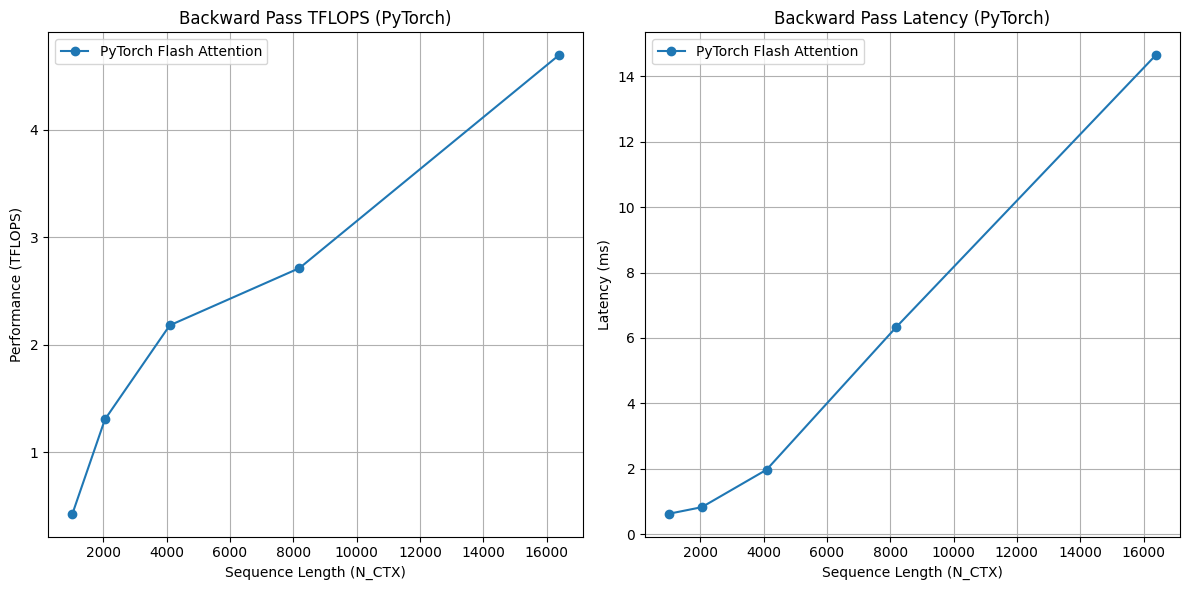

In [ ]:
def benchmark_attention_backward_pytorch(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda", requires_grad=True)
    sm_scale = 0.5

    # Forward pass to generate outputs
    out = attention(q, k, v, causal, sm_scale)
    grad_out = torch.randn_like(out)

    # Warm-up backward pass
    out.backward(grad_out, retain_graph=True)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        out.backward(grad_out, retain_graph=True)
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    tflops = calculate_tflops(N_CTX, HEAD_DIM, BATCH, HEADS, avg_runtime)
    return avg_runtime, tflops

def plot_tflops_and_latency_pytorch():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    tflops_results = []
    latency_results = []
    for size in ctx_sizes:
        runtime, tflops = benchmark_attention_backward_pytorch(size, BATCH, HEADS, HEAD_DIM, causal)
        latency_results.append(runtime * 1000)  # Convert to ms
        tflops_results.append(tflops)
        print(f"N_CTX: {size}, Latency: {runtime * 1000:.3f} ms, TFLOPS: {tflops:.3f}")

    # Plot TFLOPS
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(ctx_sizes, tflops_results, 'o-', label='PyTorch Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Performance (TFLOPS)')
    plt.title('Backward Pass TFLOPS (PyTorch)')
    plt.grid(True)
    plt.legend()

    # Plot Latency
    plt.subplot(1, 2, 2)
    plt.plot(ctx_sizes, latency_results, 'o-', label='PyTorch Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Latency (ms)')
    plt.title('Backward Pass Latency (PyTorch)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run the PyTorch benchmark and plot
plot_tflops_and_latency_pytorch()


N_CTX: 1024, Latency: 0.313 ms
N_CTX: 2048, Latency: 0.350 ms
N_CTX: 4096, Latency: 0.698 ms
N_CTX: 8192, Latency: 1.852 ms
N_CTX: 16384, Latency: 5.746 ms


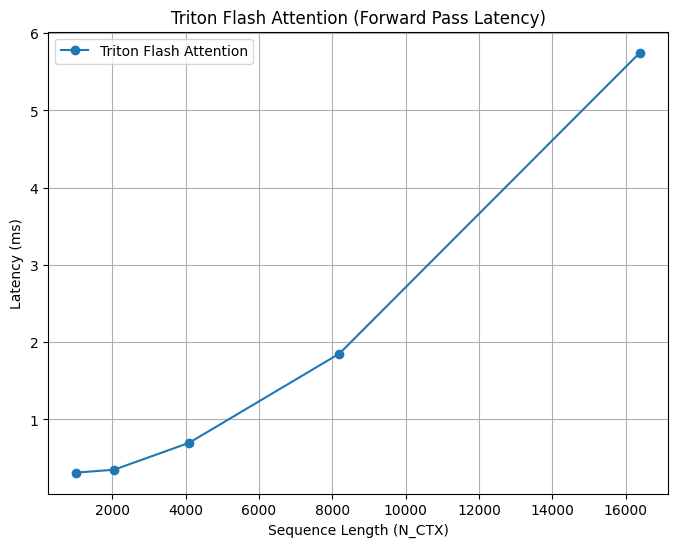

In [ ]:
import torch
import time
import matplotlib.pyplot as plt

def benchmark_forward_latency_triton(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    # Random tensor inputs
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    sm_scale = 0.5

    # Warm-up run
    _ = attention(q, k, v, causal, sm_scale)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        _ = attention(q, k, v, causal, sm_scale)
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    return avg_runtime * 1000  # Convert to milliseconds

def plot_latency_forward_triton():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    latency_results = []
    for size in ctx_sizes:
        latency = benchmark_forward_latency_triton(size, BATCH, HEADS, HEAD_DIM, causal)
        latency_results.append(latency)
        print(f"N_CTX: {size}, Latency: {latency:.3f} ms")

    # Plot Latency
    plt.figure(figsize=(8, 6))
    plt.plot(ctx_sizes, latency_results, 'o-', label='Triton Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Latency (ms)')
    plt.title('Triton Flash Attention (Forward Pass Latency)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the Triton forward latency benchmark and plot
plot_latency_forward_triton()


N_CTX: 1024, Latency: 0.366 ms
N_CTX: 2048, Latency: 0.363 ms
N_CTX: 4096, Latency: 0.680 ms
N_CTX: 8192, Latency: 1.843 ms
N_CTX: 16384, Latency: 5.702 ms


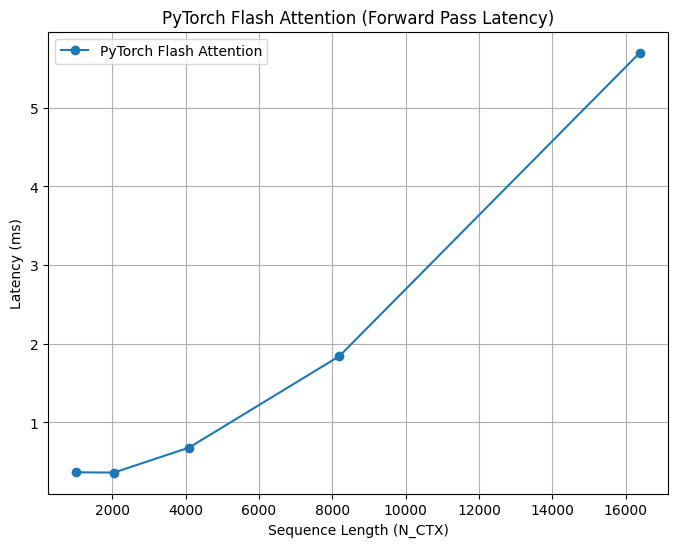

In [ ]:
def benchmark_forward_latency_pytorch(N_CTX, BATCH, HEADS, HEAD_DIM, causal, iters=10):
    # Random tensor inputs
    q = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    k = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    v = torch.randn((BATCH, HEADS, N_CTX, HEAD_DIM), dtype=torch.float16, device="cuda")
    sm_scale = 0.5

    # Warm-up run
    _ = attention(q, k, v, causal, sm_scale)

    total_time = 0.0
    for _ in range(iters):
        torch.cuda.synchronize()
        start = time.perf_counter()
        _ = attention(q, k, v, causal, sm_scale)
        torch.cuda.synchronize()
        total_time += time.perf_counter() - start

    avg_runtime = total_time / iters
    return avg_runtime * 1000  # Convert to milliseconds

def plot_latency_forward_pytorch():
    BATCH, HEADS, HEAD_DIM = 1, 2, 64
    causal = True
    ctx_sizes = [2**i for i in range(10, 15)]  # Sequence lengths from 1024 to 16384

    latency_results = []
    for size in ctx_sizes:
        latency = benchmark_forward_latency_pytorch(size, BATCH, HEADS, HEAD_DIM, causal)
        latency_results.append(latency)
        print(f"N_CTX: {size}, Latency: {latency:.3f} ms")

    # Plot Latency
    plt.figure(figsize=(8, 6))
    plt.plot(ctx_sizes, latency_results, 'o-', label='PyTorch Flash Attention')
    plt.xlabel('Sequence Length (N_CTX)')
    plt.ylabel('Latency (ms)')
    plt.title('PyTorch Flash Attention (Forward Pass Latency)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Run the PyTorch forward latency benchmark and plot
plot_latency_forward_pytorch()
